In [1]:
from medpredictor import Graph, Encoder, Config, Utils
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTENC
from IPython.display import Markdown

### **Setting up the dataframe**

In [2]:
df = pd.read_csv(Config.data_cleaned_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  object 
 1   HighBP                253680 non-null  object 
 2   HighChol              253680 non-null  object 
 3   CholCheck             253680 non-null  object 
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  object 
 6   Stroke                253680 non-null  object 
 7   HeartDiseaseorAttack  253680 non-null  object 
 8   PhysActivity          253680 non-null  object 
 9   Fruits                253680 non-null  object 
 10  Veggies               253680 non-null  object 
 11  HvyAlcoholConsump     253680 non-null  object 
 12  AnyHealthcare         253680 non-null  object 
 13  NoDocbcCost           253680 non-null  object 
 14  GenHlth               253680 non-null  object 
 15  

### **Utils**

In [3]:
def model_metrics(y_test, y_pred, average):
    met = {'Accuracy':round((metrics.accuracy_score(y_test, y_pred) * 100), 2),
              'Recall': round((metrics.recall_score(y_test, y_pred, average=average) * 100), 2),
              'Precision': round((metrics.precision_score(y_test, y_pred, average=average) * 100), 2),
              'F1-score': round((metrics.f1_score(y_test, y_pred, average=average) * 100), 2)
              }
    return met

def show_metrics(met):
    for key, value in met.items():
        display(Markdown(f"{key}: **{value}**%"))
    return


### **Feature engineering**

In [4]:
df_enc_dict = {}

df_dec_dict = {}

orders = {}

num_columns = ['BMI', 'MentHlth', 'PhysHlth']

df_copy = df.drop(columns=num_columns)

enc = Encoder()

orders = {'Age': Utils.values_age_order,
          'GenHlth': Utils.values_status_order,
          'Income': Utils.values_income_order,
          'Education': Utils.values_education_order,
          'Diabetes_012': Utils.values_diabetes_order}

for column in df_copy.columns:
    order = orders.get(column, None)
    if order is not None:
        enc_, dec_ = enc.ordinal_encoder_method(df=df_copy, 
                                          column_name=column, 
                                          order=order)
        df_enc_dict[column] = pd.DataFrame({column + '_enc': enc_})
        df_dec_dict[column] = pd.DataFrame({column + '_dec': dec_})
        continue
    enc_, dec_ = enc.label_encoder_method(df=df_copy,
                                    column_name=column)
    df_enc_dict[column] = pd.DataFrame({column + '_enc': enc_})
    df_dec_dict[column] = pd.DataFrame({column + '_dec': dec_})

df_numerics = enc.robust_scaler_method(df=df, columns_name=num_columns)

df_enc_dict.update({'numerics':df_numerics})

df_enc = pd.concat(list(df_enc_dict.values()), axis=1)
df_dec = pd.concat(list(df_dec_dict.values()), axis=1)

df_enc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Diabetes_012_enc          253680 non-null  float64
 1   HighBP_enc                253680 non-null  int64  
 2   HighChol_enc              253680 non-null  int64  
 3   CholCheck_enc             253680 non-null  int64  
 4   Smoker_enc                253680 non-null  int64  
 5   Stroke_enc                253680 non-null  int64  
 6   HeartDiseaseorAttack_enc  253680 non-null  int64  
 7   PhysActivity_enc          253680 non-null  int64  
 8   Fruits_enc                253680 non-null  int64  
 9   Veggies_enc               253680 non-null  int64  
 10  HvyAlcoholConsump_enc     253680 non-null  int64  
 11  AnyHealthcare_enc         253680 non-null  int64  
 12  NoDocbcCost_enc           253680 non-null  int64  
 13  GenHlth_enc               253680 non-null  f

In [5]:
X_h1 = df_enc.drop(columns=['MentHlth', 'PhysHlth',
                            'Diabetes_012_enc', 'CholCheck_enc',
                            'AnyHealthcare_enc', 'NoDocbcCost_enc',
                            'Education_enc', 'Income_enc' 
                            ])
y_h1 = df_enc['Diabetes_012_enc']

X_h2 = df_enc.drop(columns=['MentHlth', 'PhysHlth',
                            'Stroke_enc', 'AnyHealthcare_enc',
                            'NoDocbcCost_enc', 'Education_enc',
                            'Income_enc'])
y_h2 = df_enc['Stroke_enc']

X_h3 = df_enc.drop(columns=['MentHlth', 'PhysHlth',
                            'HeartDiseaseorAttack_enc','AnyHealthcare_enc',
                            'NoDocbcCost_enc', 'Education_enc',
                            'Income_enc'])
y_h3 = df_enc['HeartDiseaseorAttack_enc']

### **Hypotesis n° 1**

How do a person's demographic characteristics, habits and physical conditions influence the likelihood of developing diabetes, according to the indicator recorded?

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_h1, y_h1, test_size=0.3, random_state=42)

In [7]:
sm = SMOTENC(categorical_features=list(range(len(X_h1.columns)-1)))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#### **K-Nearest Neighbors**

In [8]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **74.83**%

Recall: **74.83**%

Precision: **79.6**%

F1-score: **76.99**%

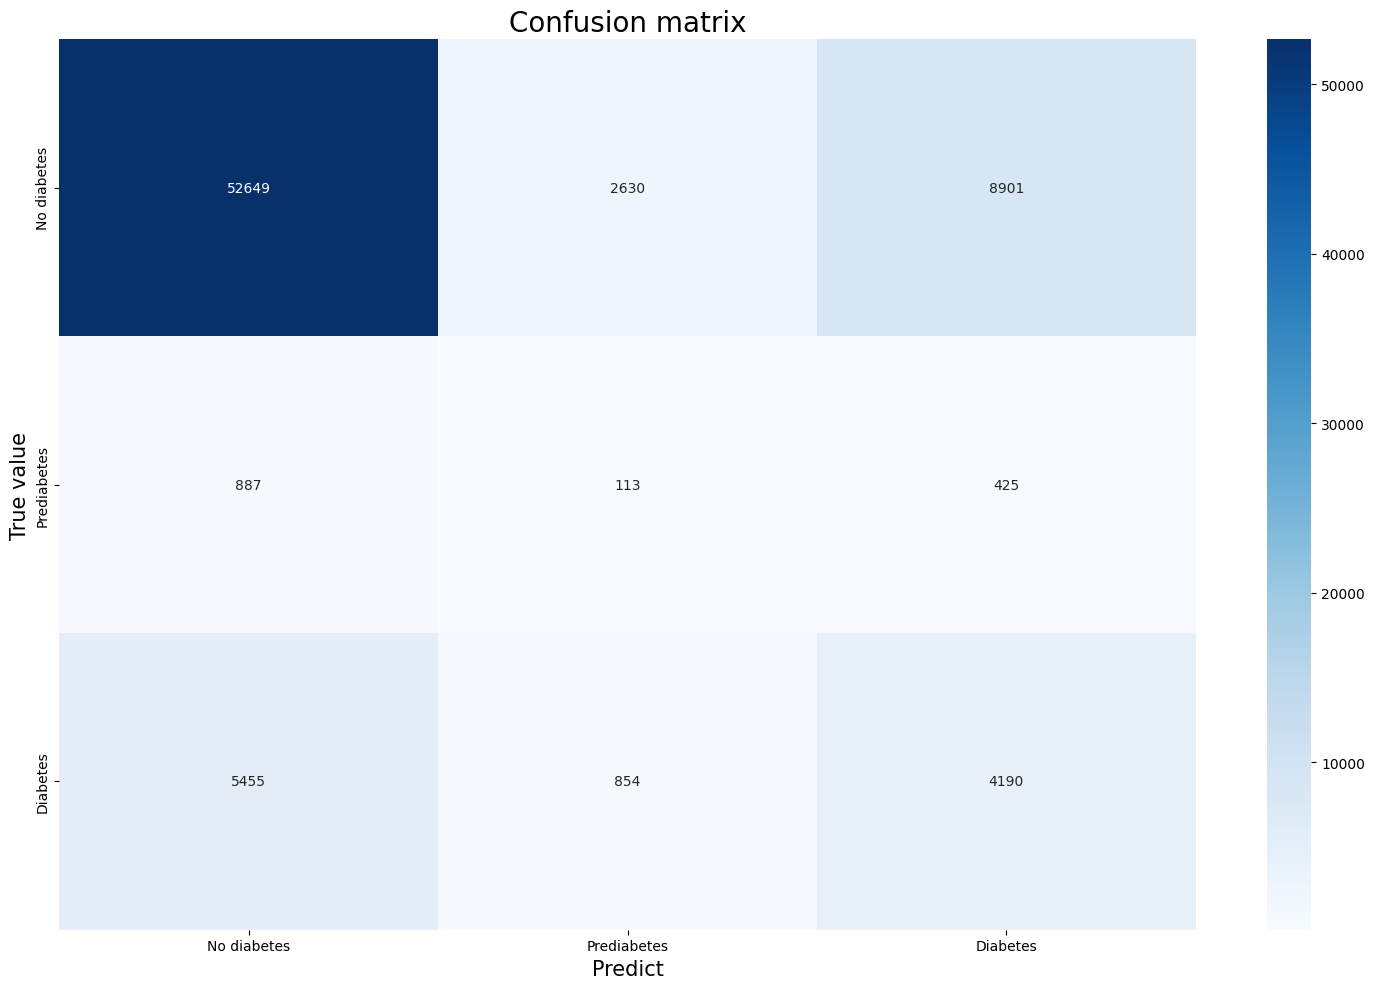

In [11]:
met = model_metrics(y_test, y_pred, 'weighted')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=Utils.values_diabetes_order,
                       yticklabels=Utils.values_diabetes_order
                       )

**Model's metrics analysis**

* **Accuracy**: The model achieved an accuracy of **74.83%**, indicating that approximately three-quarters of the predictions were correct. Although this is an acceptable result, there is room for improvement, especially considering the classification of pre-diabetes.
* **Recall**: With a value of **74.83%**, recall suggests that the model has a moderate ability to correctly identify positive cases, but also implies that there is a significant amount of false negatives.
* **Precision**: The accuracy of **79.6%** indicates that the majority of positive predictions are correct, suggesting that the model performs well in minimising false positives.
* **F1-Score**: The F1-score of **76.99%** is a balance between precision and recall, confirming decent model performance, albeit with opportunities for optimisation.

**Confusion matrix analysis**

The model demonstrates a moderate performance, achieving an accuracy of **74.83%**. Precision slightly surpasses recall, suggesting that the model is more cautious when predicting positive cases. It prioritises certainty in its possitive classifications, but this comes at the cost of overlooking some actual cases.

However, the high number of false negatives, particularly in the "Diabetes" category, highlights a significant weakness in identifying individuals who truly hace the disease. This could be concerning in medical applications, as some diabetic patients might go undiagnosed.

The confusion matrix analysis reveals that the model struggles to distinguish between "Prediabetes" and "Diabetes". This is expected, given that prediabetes represents an intermediate condition. Applying model optimisation techniques could help reduce this misclassification.

#### **Random Forest**

In [12]:
param_dist = {'n_estimators': randint(20, 30),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train_resampled, y_train_resampled)

best_rf = rand_search.best_estimator_

display(Markdown(f"Best hyperparameters: {rand_search.best_params_}"))

Best hyperparameters: {'max_depth': 17, 'n_estimators': 22}

Taking into account this hyperparameters, let's train a new Random Forest Classifier

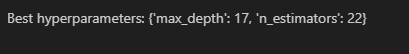

In [13]:
model = RandomForestClassifier(n_estimators=22, 
                               max_depth=17)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **70.33**%

Recall: **70.33**%

Precision: **82.63**%

F1-score: **75.15**%

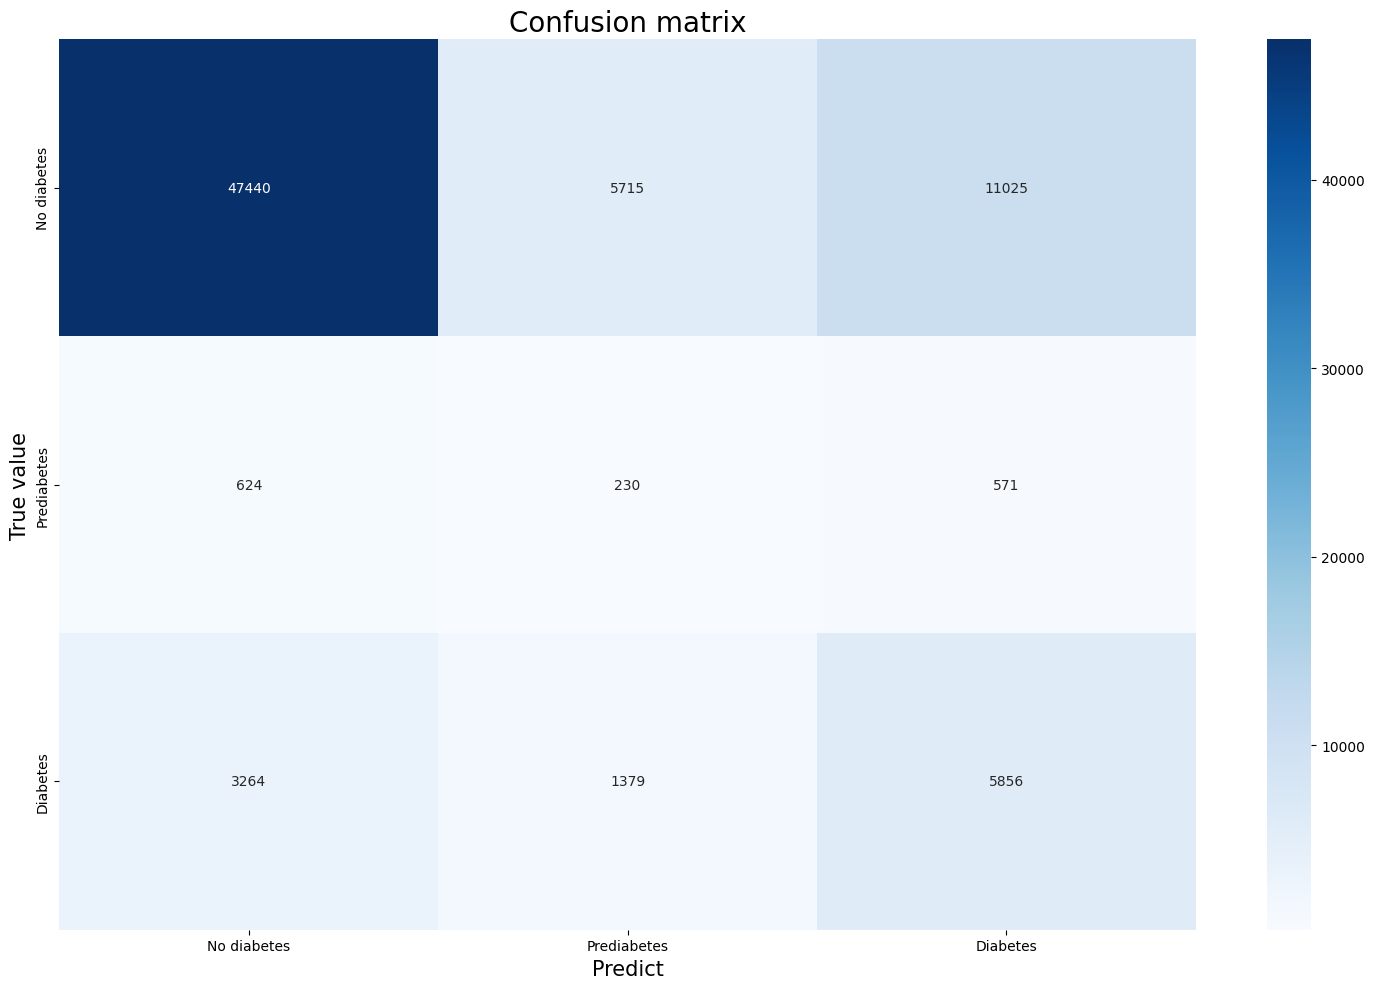

In [14]:
met = model_metrics(y_test, y_pred, 'weighted')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=Utils.values_diabetes_order,
                       yticklabels=Utils.values_diabetes_order
                       )

**Model's metrics analysis**

* **Accuracy**: The model correctly classifies **70.33%** of cases, indicating acceptable performance, although with room for improvement.
* **Recall**: The model's ability to correctly identify positive cases is **70.33%**, suggesting moderate detection of the classes of interest, but with a significant number of false negatives
* **Precision**: **82.63%** of the cases that the model predicts as positive actually are, indicating good classification ability, although it may be biased towards a majority class.
* **F1-Score**: The balance between precision and recall reaches **75.15%**, reflecting an acceptable performance, although there is still room to optimise the model's classification.

**Confusion matrix analysis**

The model has a relatively high precision (**82.63%**), meaning that when it predicts someone has a condition (prediabetes or diabetes), it is more likely to be correct.

However, the recall is lower (**70.33%**), indicating that the model struggles to identify all individuals who actually have a condition, especially diabetes (many false negatives in the "Diabetes" class). The model frequently confuses prediabetes with not having diabetes and vice versa, which is understandable since prediabetes is an intermediate state.

Overall, the model has a moderate performance (**70.33%** accuracy).


### **Hypotesis n° 2**

How do a person's demographics, habits and physical conditions influence the likelihood of having a stroke?

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_h2, y_h2, test_size=0.3, random_state=42)

In [7]:
sm = SMOTENC(categorical_features=list(range(len(X_h2.columns)-1)))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#### **K-Nearest Neighbors**

In [15]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **88.44**%

Recall: **27.16**%

Precision: **11.4**%

F1-score: **16.05**%

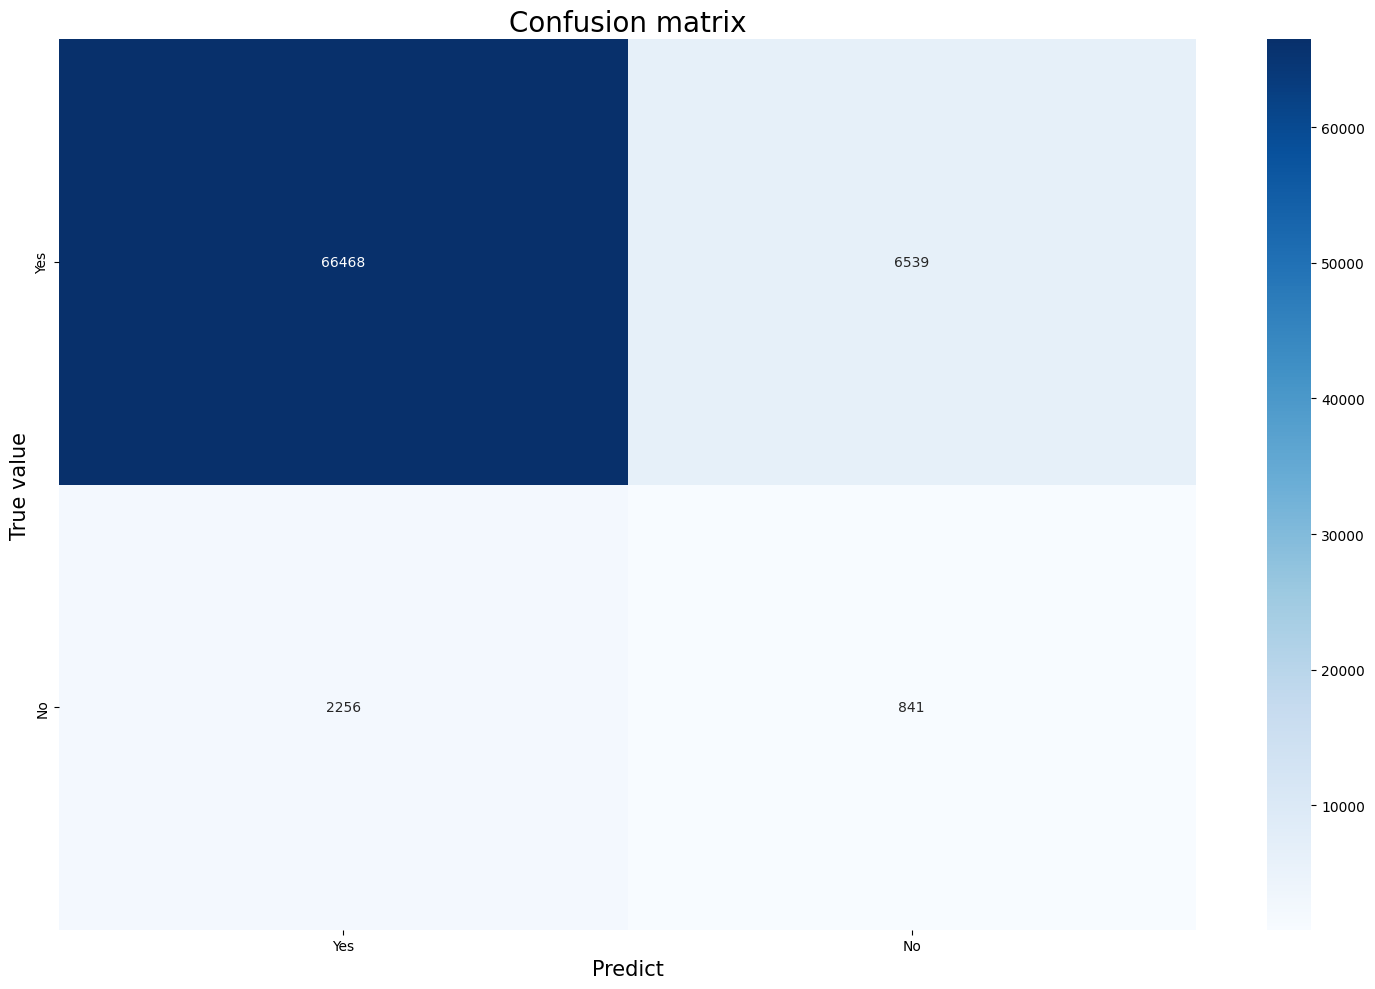

In [16]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

**Model's metrics analysis**

* **Accuracy**: The model has an accuracy of **88.44%**, which at first glance could be considered a good performance. However, given that the aim is to correctly identify those at increased risk of stroke, this metric alone is not sufficient to assess its usefulness. It is possible that the model is biased towards the majority class, which reduces its effectiveness in detecting positive cases.
* **Recall**: With a value of **27.16%**, the model has a limited ability to correctly identify people who have actually suffered a stroke. This means that it is missing a high percentage of individuals at risk, which is worrying from a medical perspective, as a false negative could imply the omission of a key preventive intervention.
* **Precision**: The precision of **11.4%** indicates that, when the model predicts that a person is prone to stroke, it is mostly wrong. This suggests that many of the people identified as ‘at risk’ are not really at risk, which could lead to false alarms in a clinical setting.
* **F1-Score**: With a value of **16.05%**, this metric confirms the low balance between precision and recall. Such a low F1-score suggests that the model is not reliable in answering the question posed, as it fails to adequately identify those at risk and does not provide sufficiently accurate predictions.

**Confusion matrix analysis**

* **True positives cases** (TP): The model correctly identified 66468 cases of people at risk of stroke. However, when considering the high number of false negatives, it is clear that there are still many people at risk that the model is not detecting.
* **False positives cases** (FP): 2256 cases were detected where the model wrongly predicted a stroke risk when the person was not actually at risk. Although this number is relatively low compared to true positives, it is still a concern in terms of diagnostic efficiency.
* **False negative cases** (FN): With 6539 cases where the model did not correctly identify people at risk, a major limitation in stroke detection is observed. In a clinical context, these errors can be critical, as they can lead to a lack of preventive measures in individuals who really need it.
* **True negative cases** (TN): Finally, 841 individuals were correctly classified as not stroke-prone. However, the low number of true negatives compared to true positives could indicate an imbalance in the classification of the negative class.

#### **Random Forest**

In [10]:
param_dist = {'n_estimators': randint(20, 30),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train_resampled, y_train_resampled)

best_rf = rand_search.best_estimator_

display(Markdown(f"Best hyperparameters: {rand_search.best_params_}"))

Best hyperparameters: {'max_depth': 18, 'n_estimators': 28}

Taking into account this hyperparameters, let's train a new Random Forest Classifier

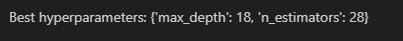

In [17]:
model = RandomForestClassifier(n_estimators=28, 
                               max_depth=18)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **86.33**%

Recall: **36.71**%

Precision: **11.87**%

F1-score: **17.94**%

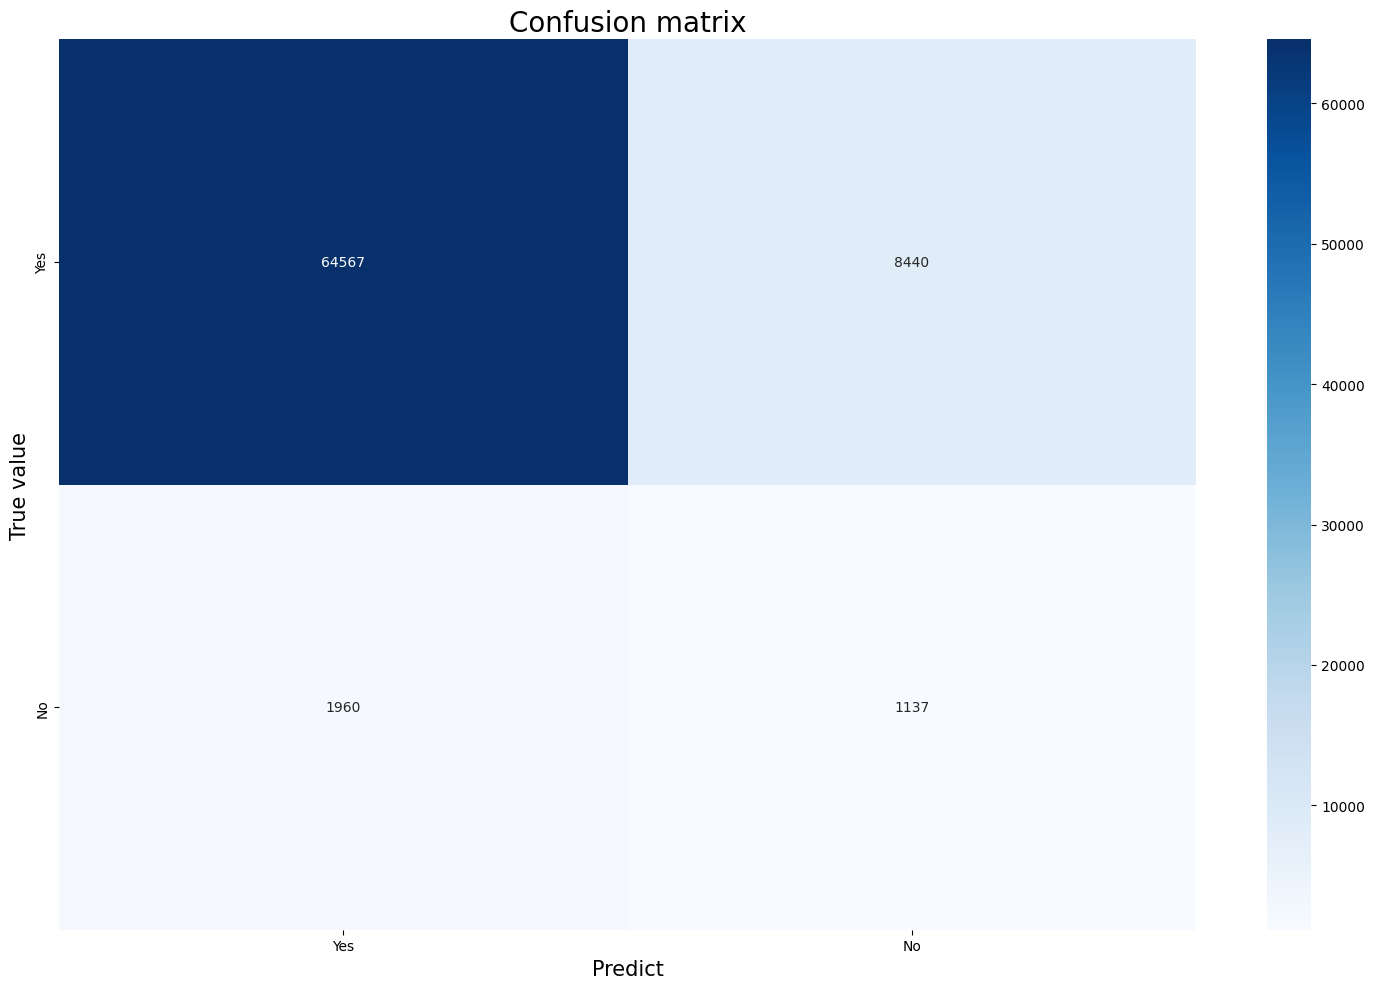

In [18]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

**Model's metrics analysis**

* **Accuracy**: The model has an accuracy of **86.33%**, indicating that it broadly classifies most cases correctly. However, given that the class of greatest interest is people at risk of stroke, it is crucial to look at more specific metrics.
* **Recall**: The model has a recall of **36.71%**, which means that it manages to identify just over a third of real stroke cases. While this is an improvement over the previous version, it is still a low value for a problem where it is essential to minimise false negatives.
* **Precision**: Precision is **11.87%**, indicating that only about 1 in 9 people classified as ‘at risk’ are actually at risk. This low value suggests that the model still struggles to make reliable predictions.
* **F1-Score**: The F1-Score is **17.94%**, reflecting a low balance between precision and recall. Although improved over the previous version, it is still insufficient for an effective prediction tool in the medical domain.

**Confusion matrix analysis**

* **True positives cases** (TP): 64567 people were correctly identified as being at risk. This represents an improvement in the detection of positive cases, but many false negatives remain.
* **False positives cases** (FP): 8440 people who are actually at risk were misclassified as not at risk. This number remains high and represents a great opportunity for improvement.
* **False negative cases** (FN): 1960 people were incorrectly classified as at risk when they were not. Although not an extremely high number, it contributes to the low precision of the model.
* **True negative cases** (TN): 1137 people were correctly classified as not at risk.

#### **Hypotesis n° 3**

How do a person's demographics, habits and physical conditions influence the likelihood of having a heart attack?

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_h3, y_h3, test_size=0.3, random_state=42)

In [20]:
sm = SMOTENC(categorical_features=list(range(len(X_h2.columns)-1)))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#### **K-Nearest Neighbors**

In [21]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **83.3**%

Recall: **40.72**%

Precision: **25.36**%

F1-score: **31.26**%

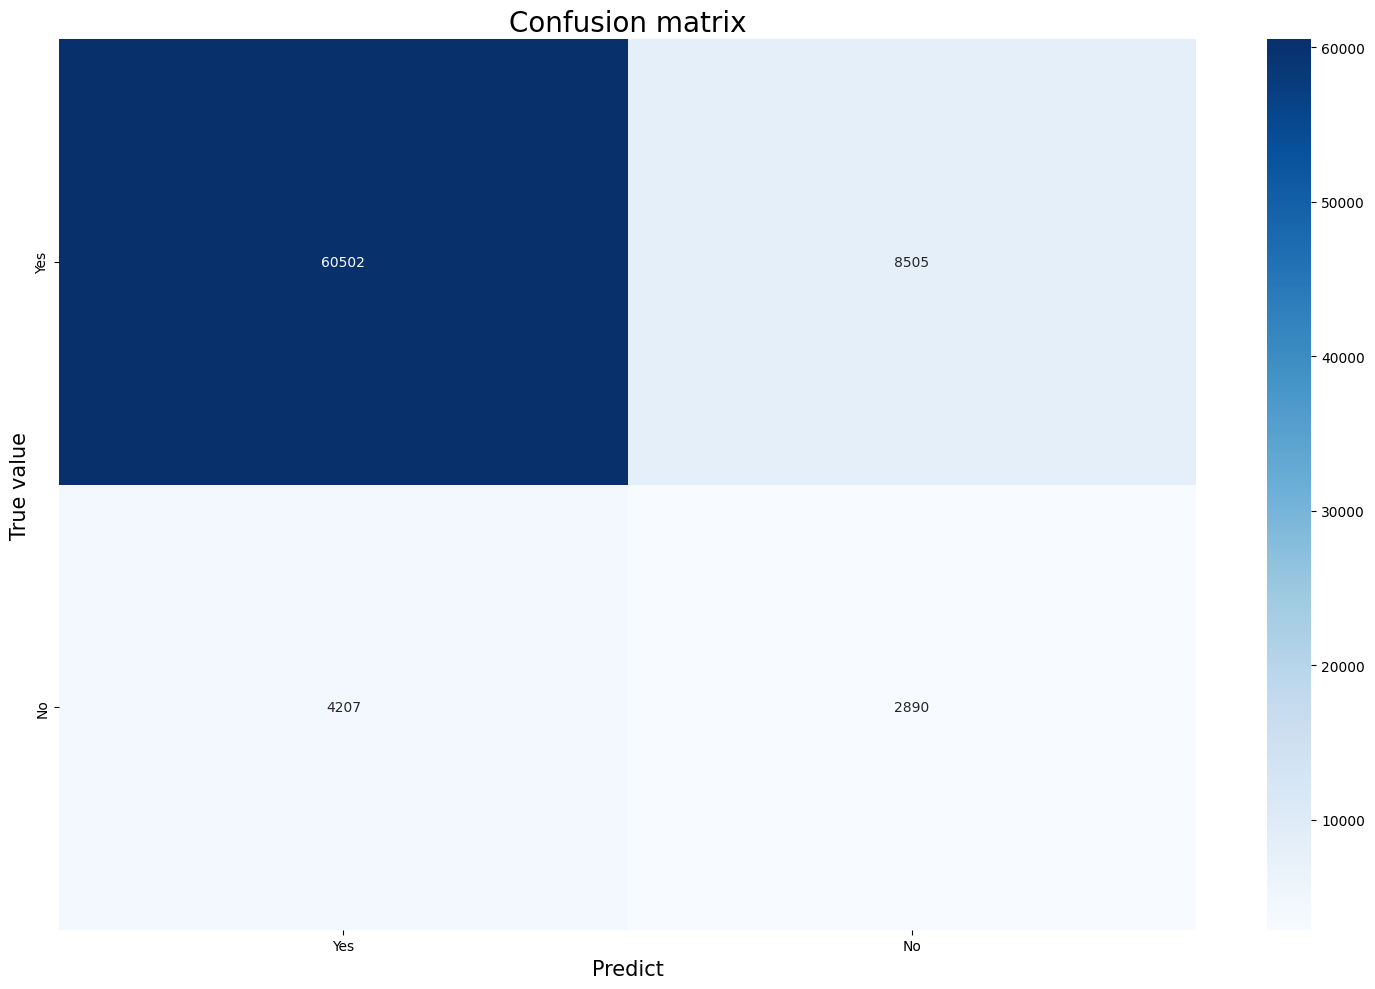

In [22]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

**Model's metrics analysis**

* **Accuracy**: The accuracy of the model is **83.3%**, which at first glance may appear to be a good performance. However, this metric alone is not sufficient to assess the effectiveness of the model, especially in problems where classes may be unbalanced.
* **Recall**: With a value of **40.72%**, the model has a moderate sensitivity for identifying people who have suffered a heart attack. This means that **40.72%** of actual heart attack cases were correctly identified. However, this percentage indicates that the model is missing a significant number of positive cases, which can be critical in a medical context, where correctly identifying patients at risk is vital.
* **Precision**: The precision of the model is **25.36%**, which implies that when the model predicts that a person has suffered a heart attack, only **25.36%** of the cases are correct. This value is relatively low and suggests that there is a considerable amount of false positives, which could lead to misdiagnosis and unnecessary assessment of patients who are not really at risk.
* **F1-Score**: With a value of **31.26%**, this metric, which combines precision and recall, confirms that the model has limited performance in accurately identifying heart attack cases. The low F1-score indicates that the balance between detecting positive cases and reducing false positives is poor.

**Confusion matrix analysis**

* **True positives cases** (TP): The model correctly identified 60502 cases where a person actually suffered a heart attack. This is a considerable number, but when analysed together with the false negatives, there are a significant number of cases that the model failed to detect. 
* **False positives cases** (FP): 4207 cases were recorded where the model erroneously predicted that a person had suffered a heart attack when they had not. While the impact of these errors may not be as critical as false negatives, they could lead to unnecessary concern and inefficient use of health resources.
* **False negative cases** (FN): With 8505 cases where the model did not correctly detect a heart attack, a significant problem is evident. These errors can have serious consequences, as they mean that many people at risk will not receive timely preventive care.
* **True negative cases** (TN):  The model correctly classified 2890 cases as not having a heart attack. Although this value is relatively low compared to true positives, it indicates that the model has some degree of reliability in identifying individuals who are not at risk.

#### **Random Forest**

In [23]:
param_dist = {'n_estimators': randint(20, 30),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train_resampled, y_train_resampled)

best_rf = rand_search.best_estimator_

display(Markdown(f"Best hyperparameters: {rand_search.best_params_}"))

Best hyperparameters: {'max_depth': 17, 'n_estimators': 23}

Taking into account this hyperparameters, let-s train a new Random Forest Classifier

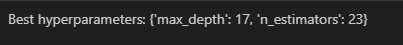

In [24]:
model = RandomForestClassifier(n_estimators=23, 
                               max_depth=17)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **79.75**%

Recall: **60.93**%

Precision: **25.49**%

F1-score: **35.94**%

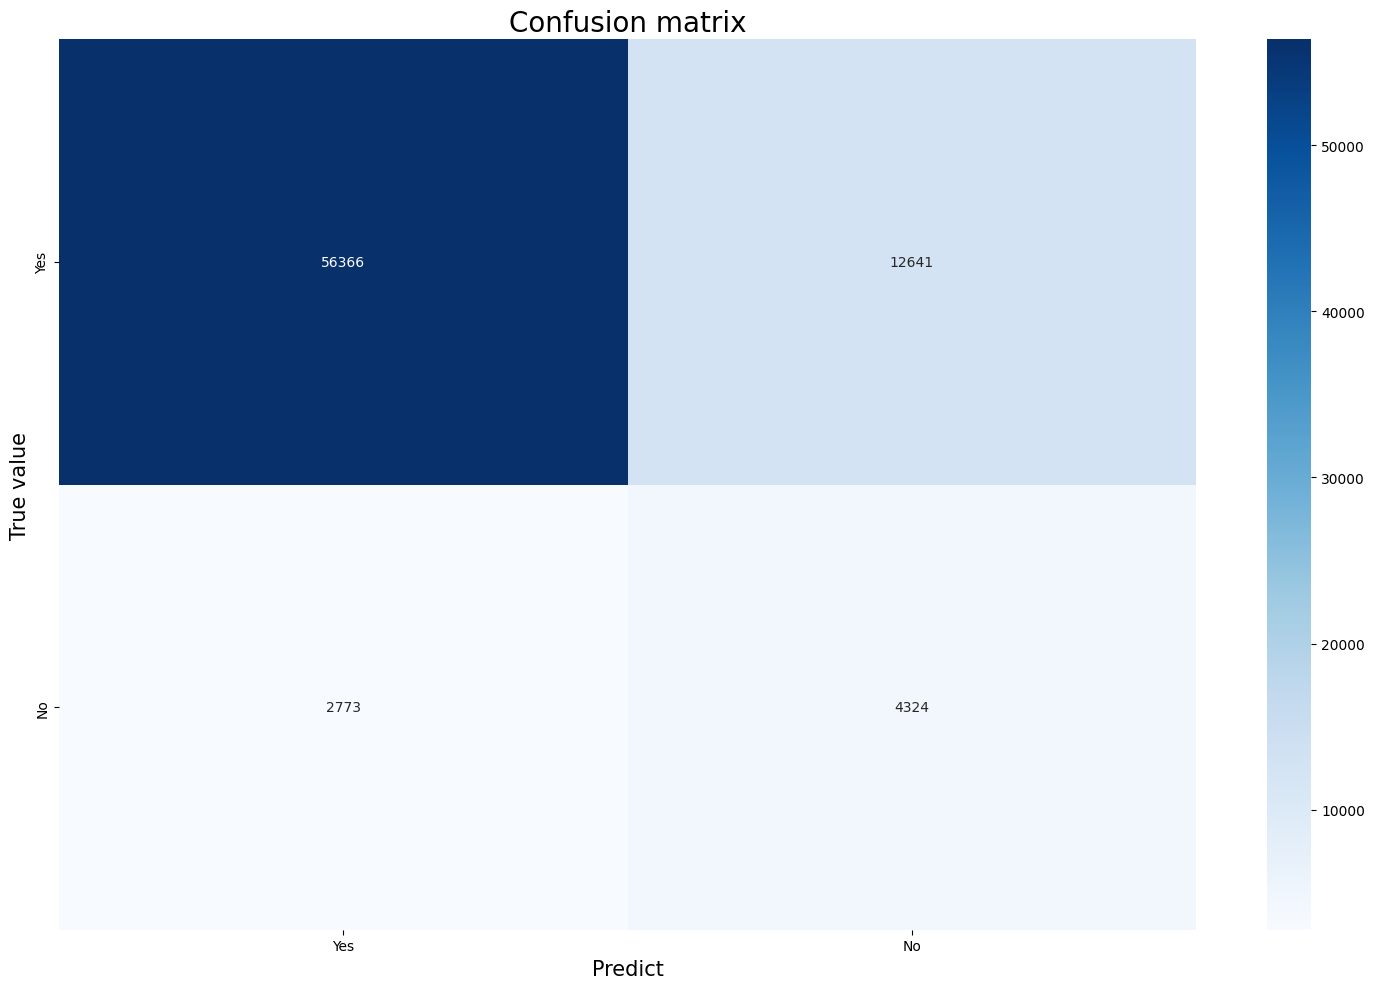

In [25]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

**Model's metrics analysis**

* **Accuracy**: The accuracy of the model is **79.75%**, which at first glance may appear to be a good performance. However, this metric alone is not sufficient to assess the effectiveness of the model, especially in problems where classes may be unbalanced. 
* **Recall**:  With a value of **60.93%**, the model has a moderate sensitivity for identifying people who have suffered a heart attack. This means that **60.93%** of actual heart attack cases were correctly identified. Although improved over previous version, there is still a considerable percentage of positive cases that are not being detected, which remains a critical issue in a medical context.
* **Precision**: The precision of the model is **25.49%**, which implies that when the model predicts that a person has suffered a heart attack, only **25.49%** of the cases are correct. This is still relatively low and suggests that there is a considerable amount of false positives, which could lead to misdiagnosis and unnecessary assessment of patients who are not really at risk.
* **F1-Score**:  With a value of **35.94%**, this metric, which combines precision and recall, confirms that the model has improved in accurately identifying heart attack cases, although it still has limited performance. The low F1-score indicates that the balance between detecting positive cases and reducing false positives still needs improvement.

**Confusion matrix analysis**

* **True positives cases** (TP): The model correctly identified 56366 cases where a person actually suffered a heart attack. This is a significant number, but when analysed in conjunction with the false negatives, there are still a significant number of cases that the model fails to detect.
* **False positives cases** (FP): 2773 cases were recorded where the model erroneously predicted that a person had suffered a heart attack when they had not. While the impact of these errors may not be as critical as false negatives, they could lead to unnecessary concern and inefficient use of health resources.
* **False negative cases** (FN): With 12641 cases where the model did not correctly detect a heart attack, a significant problem is evident. These errors can have serious consequences, as they mean that many people at risk will not receive timely preventive care.
* **True negative cases** (TN): The model correctly classified 4324 cases as not having a heart attack. Although this value is still relatively low, it indicates that the model has some degree of reliability in identifying individuals who are not at risk.